# Analysis of Medicare-Registered Hospital Performance Metrics

## Fetching data via CMS API
Obtaining the data from the CMS (Centers for Medicare & Medicaid Services) website using their API lets us update the dataset
with new data whenever we choose to do so (or we can implement updates programmatically).
This functionality is useful because this dataset will be updated annually.

Since the data definitions are unlikely to change and CMS has a PDF with that information
on their website, I'd rather read the schema from the PDF. I've downloaded it directly
and placed it in the folder containing the hospital information dataset.

In [75]:
import requests
import pandas as pd
import json

# send a GET request to fetch dataset metadata
response = requests.get(r'https://data.cms.gov/provider-data/api/1/metastore/schemas/dataset/items/xubh-q36u')
response.raise_for_status() # check to see if request fails

# extract response in JSON format
data = response.json()
# extract download URL from JSON
download_url = data['distribution'][0]['downloadURL']

# pandas can read the csv directly from the URL
df = pd.read_csv(download_url)

# save df as a .csv file locally
df.to_csv(r'C:\Users\patri\OneDrive\Documents\Hospital Data\Medicare_Registered_Hospitals_Information.csv',
          index = False)

print(r'Dataset downloaded and saved at C:\Users\patri\OneDrive\Documents\Hospital Data\Medicare_Registered_Hospitals_Information.csv')
df.head()

Dataset downloaded and saved at C:\Users\patri\OneDrive\Documents\Hospital Data\Medicare_Registered_Hospitals_Information.csv


,Facility ID,Facility Name,Address,City/Town,State,ZIP Code,County/Parish,Telephone Number,Hospital Type,Hospital Ownership,...,Count of READM Measures Better,Count of READM Measures No Different,Count of READM Measures Worse,READM Group Footnote,Pt Exp Group Measure Count,Count of Facility Pt Exp Measures,Pt Exp Group Footnote,TE Group Measure Count,Count of Facility TE Measures,TE Group Footnote
0,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,Acute Care Hospitals,Government - Hospital District or Authority,...,0,10,1,NaN,8,8,NaN,12,10,NaN
1,010005,MARSHALL MEDICAL CENTERS,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,(256) 593-8310,Acute Care Hospitals,Government - Hospital District or Authority,...,0,10,0,NaN,8,8,NaN,12,11,NaN
2,010006,NORTH ALABAMA MEDICAL CENTER,1701 VETERANS DRIVE,FLORENCE,AL,35630,LAUDERDALE,(256) 629-1000,Acute Care Hospitals,Proprietary,...,0,7,2,NaN,8,8,NaN,12,11,NaN
3,010007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,(334) 493-3541,Acute Care Hospitals,Voluntary non-profit - Private,...,0,5,1,NaN,8,8,NaN,12,7,NaN
4,010008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,(334) 335-3374,Acute Care Hospitals,Proprietary,...,0,2,0,NaN,8,Not Available,5.0,12,6,NaN


# Data Cleaning and Preprocessing

In [76]:
import pandas as pd

"""
I renamed some columns and dropped columns I don't plan to use.
"""
column_rename_dict = {
    "Meets criteria for promoting interoperability of EHRs": "EHR_CRITERIA",
    "Hospital overall rating": "OVERALL_RATING",
    "Count of MORT Measures Better": "FAC_MORT_BETTER",
    "Count of MORT Measures No Different": "FAC_MORT_ND",
    "Count of MORT Measures Worse": "FAC_MORT_W",
    "Count of Safety Measures Better": "SAFETY_BETTER",
    "Count of Safety Measures No Different": "SAFETY_ND",
    "Count of Safety Measures Worse": "SAFETY_WORSE",
    "Count of READM Measures Better": "READM_BETTER",
    "Count of READM Measures No Different": "READM_ND",
    "Count of READM Measures Worse": "READM_W",
}

df.rename(columns = column_rename_dict, inplace = True)

# drop columns we don't want to use
df_drop = df
df_drop = df_drop.drop(columns = [
                              'Hospital overall rating footnote',
                              'MORT Group Measure Count', 
                              'Count of Facility MORT Measures','MORT Group Footnote',
                              'Safety Group Measure Count', 
                              'Count of Facility Safety Measures',
                              'Safety Group Footnote',
                              'READM Group Measure Count', 
                              'Count of Facility READM Measures','READM Group Footnote',
                              'Pt Exp Group Measure Count',
                              'Count of Facility Pt Exp Measures',
                              'Pt Exp Group Footnote',
                              'TE Group Measure Count',
                              'Count of Facility TE Measures',
                              'TE Group Footnote'
                            ]
                 )

In [77]:
import pandas as pd
import numpy as np
"""
Some data cleaning and reformatting.
"""
#EHR_CRITERIA has NaN that doesn't match the type for 'Y'. Changing to 'N'
df_drop['EHR_CRITERIA'].fillna('N', inplace = True)

#Changing rating 'not available' to NaN and converting ratings to numeric 
overall_rating_unique = df['OVERALL_RATING'].unique()
df_drop['OVERALL_RATING'].replace('Not Available', np.nan, inplace = True)
df_drop['OVERALL_RATING'] = pd.to_numeric(df_drop['OVERALL_RATING'], 
                                          errors = 'coerce', 
                                          downcast = 'integer')

# Replace NaN with 0 and replace negative values with 0 for the measurement columns
measurement_columns = [
                       'OVERALL_RATING', 'FAC_MORT_BETTER', 'FAC_MORT_ND', 
                       'FAC_MORT_W','SAFETY_BETTER', 'SAFETY_ND', 'SAFETY_WORSE', 'READM_BETTER',
                       'READM_ND', 'READM_W'
                      ]
for column in measurement_columns:
    if column in df_drop.columns:
        df_drop[column] = pd.to_numeric(df_drop[column], errors = 'coerce') # makes str types NaN
        df_drop[column].fillna(0, inplace = True) # replaces NaN with 0
        df_drop[column] = df_drop[column].apply(lambda x: max(0, x)) # replaces negatives with 0

for column in measurement_columns:
        print(f'Column:{column}{df_drop[column].unique()}')

Column:OVERALL_RATING[3. 2. 1. 0. 4. 5.]
Column:FAC_MORT_BETTER[1. 0. 2. 3. 4. 6.]
Column:FAC_MORT_ND[5. 4. 3. 1. 7. 0. 2. 6.]
Column:FAC_MORT_W[1. 2. 0. 3. 4.]
Column:SAFETY_BETTER[2. 0. 1. 3. 4. 5. 6.]
Column:SAFETY_ND[6. 5. 2. 0. 4. 1. 3. 7. 8.]
Column:SAFETY_WORSE[0. 1. 2. 3. 4.]
Column:READM_BETTER[0. 1. 2. 4. 3. 5.]
Column:READM_ND[10.  7.  5.  2.  9.  8.  3.  4.  6.  0.  1. 11.]
Column:READM_W[1. 0. 2. 3. 5. 4. 7. 6.]


# Visualizations
The goal of these visualizations is to answer some questions about the data and provide the necessary context for our variable of interest, hospital ratings.

#### How many hospitals have ratings? What is the distribution of those ratings?

Many hospitals don't have any ratings, but we can see a fairly normal distribution of ratings. Less hospitals have ratings of 1 and 5. Most hospitals have ratings between 2-4 which we would expect.

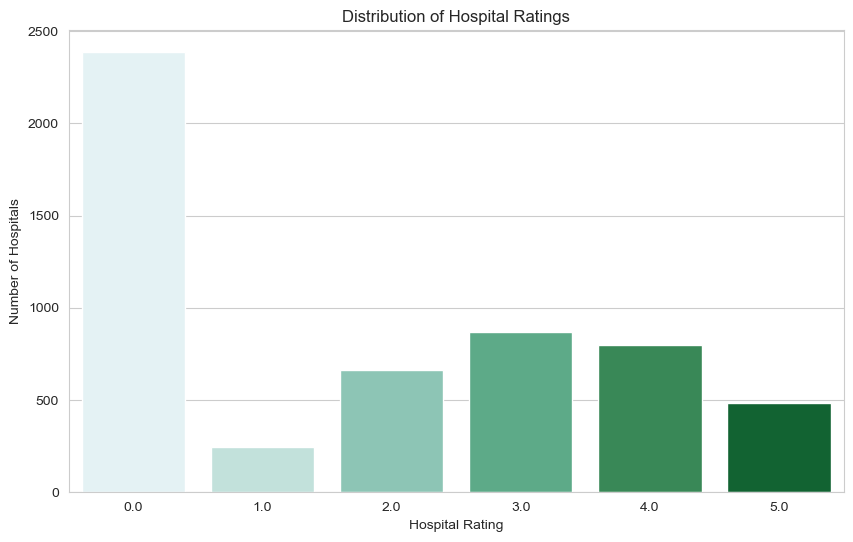

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
"""

"""
data = df_drop

# set style for seaborn plots (prefer with gridlines)
sns.set_style('whitegrid')

# create figure
plt.figure(figsize = (10,6))
sns.countplot(data = data, x = 'OVERALL_RATING', palette = 'BuGn')
plt.title('Distribution of Hospital Ratings')
plt.xlabel('Hospital Rating')
plt.ylabel('Number of Hospitals')
plt.show()

#### Do ratings differ by type of Hospital?

It looks like we don't have available rating data for Children's and Psychiatric hospitals as well as Department of Defense hospitals.

Among the hospitals we do have rating data for (VA, Critical Access and Acute Care) we can see:

-VA Hospitals generally have the highest ratings, with at least 50% being a 4.0 or above.

-Critical access hospitals have a median rating of 3.0 with a tight range for their ratings and one of these hospitals is an outlier with a rating of 1.0.

-Acute care hospitals also have a median rating of 3.0, albeit with a much larger spread than that of critical access hospitals which leads to the lowest average rating in the group.

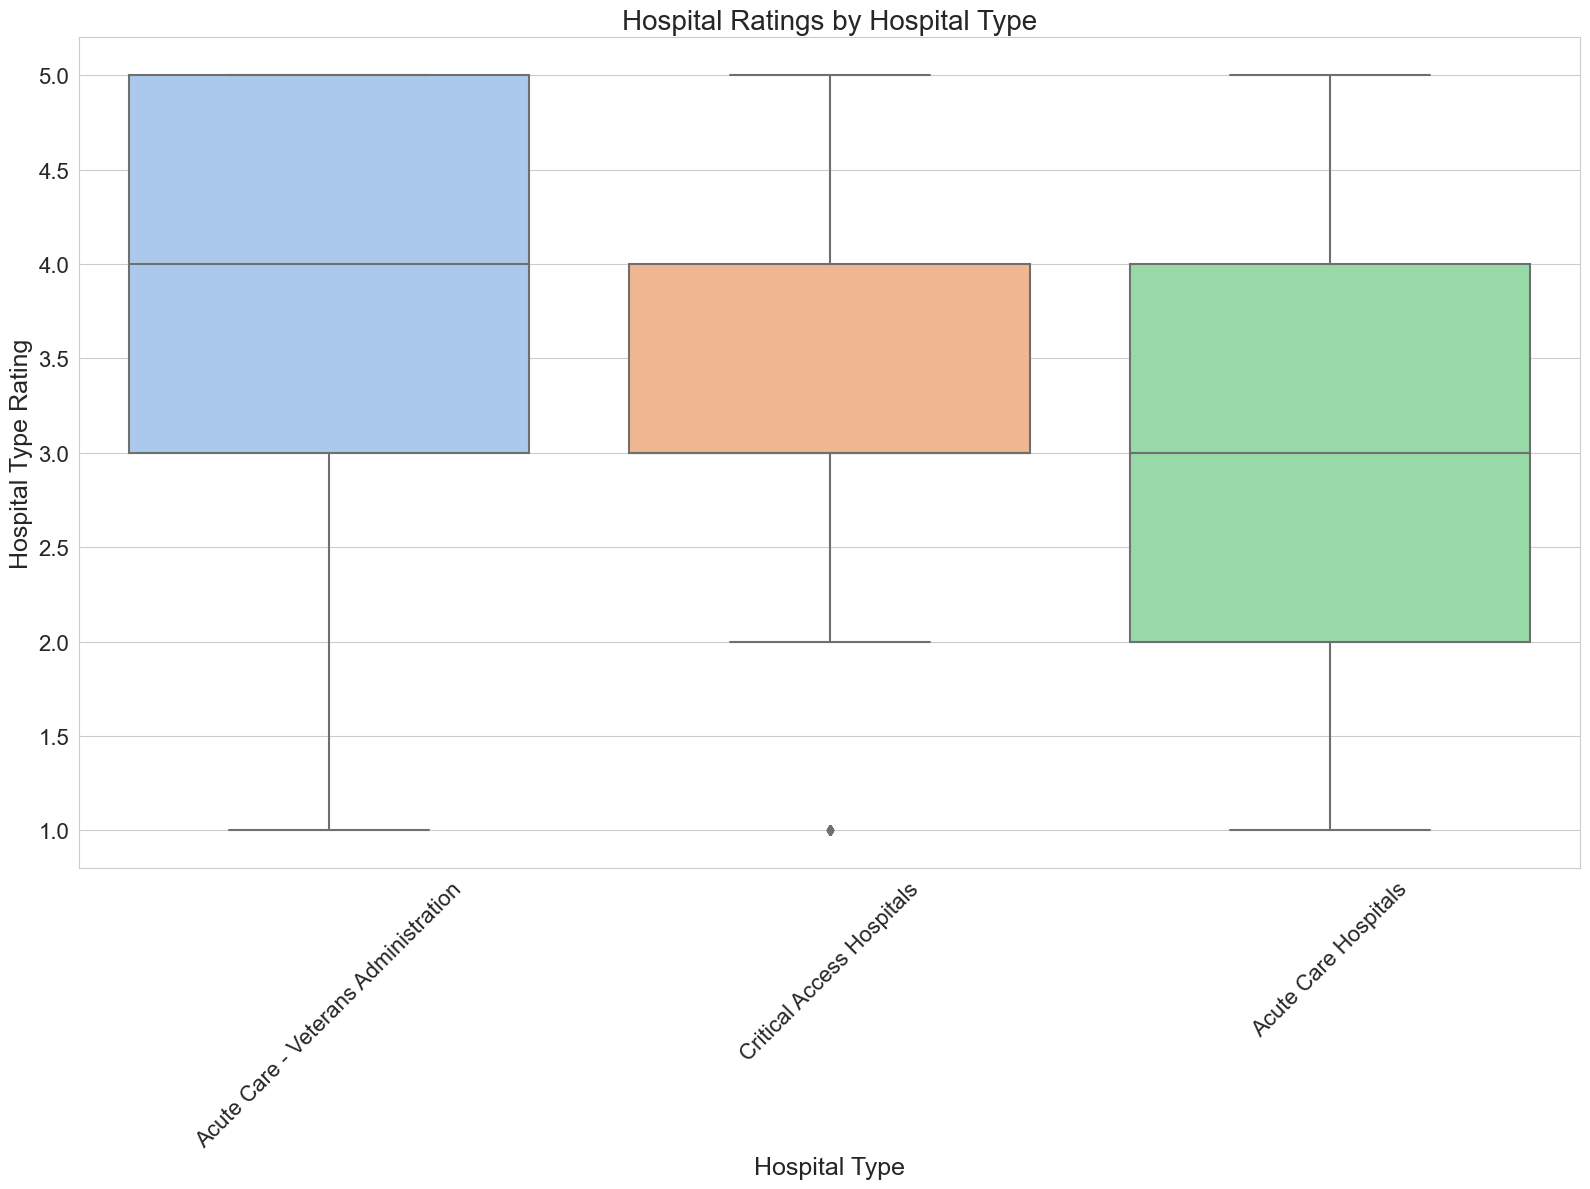

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# set fontsizes
sns.set_context(rc={
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 14
})

# filter the rating data to exclude na's and ratings of 0
data_filtered = data[data['OVERALL_RATING'].notna() & (data['OVERALL_RATING'] > 0)]
avg_ratings_filtered = data_filtered.groupby('Hospital Type')['OVERALL_RATING'].mean().sort_values(ascending = False)

plt.figure(figsize = (16, 12))
sns.boxplot(data = data_filtered, x = 'Hospital Type', y = 'OVERALL_RATING', 
            palette = 'pastel', order = avg_ratings_filtered.index)
plt.title("Hospital Ratings by Hospital Type")
plt.xlabel('Hospital Type')
plt.ylabel('Hospital Type Rating')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

#### How does ownership affect ratings?

Hospital District and Local hospitals both show a median rating of 3, with a similar spread in ratings.

State hospitals have higher medians, close to 4. The former has a narrow range, while the latter has some outliers on the lower end.

Proprietary hospitals have a median rating of 3 but exhibit a wide range of ratings, with several outliers both above and below.

Church and Private non-profit hospitals have similar distributions, with medians around 3 and most ratings between 2 and 4.

Voluntary non-profit - Other has a median rating slightly above 3 and a wider spread in ratings.

Tribal hospitals, while few in number, seem to have higher ratings, with a median of 4.

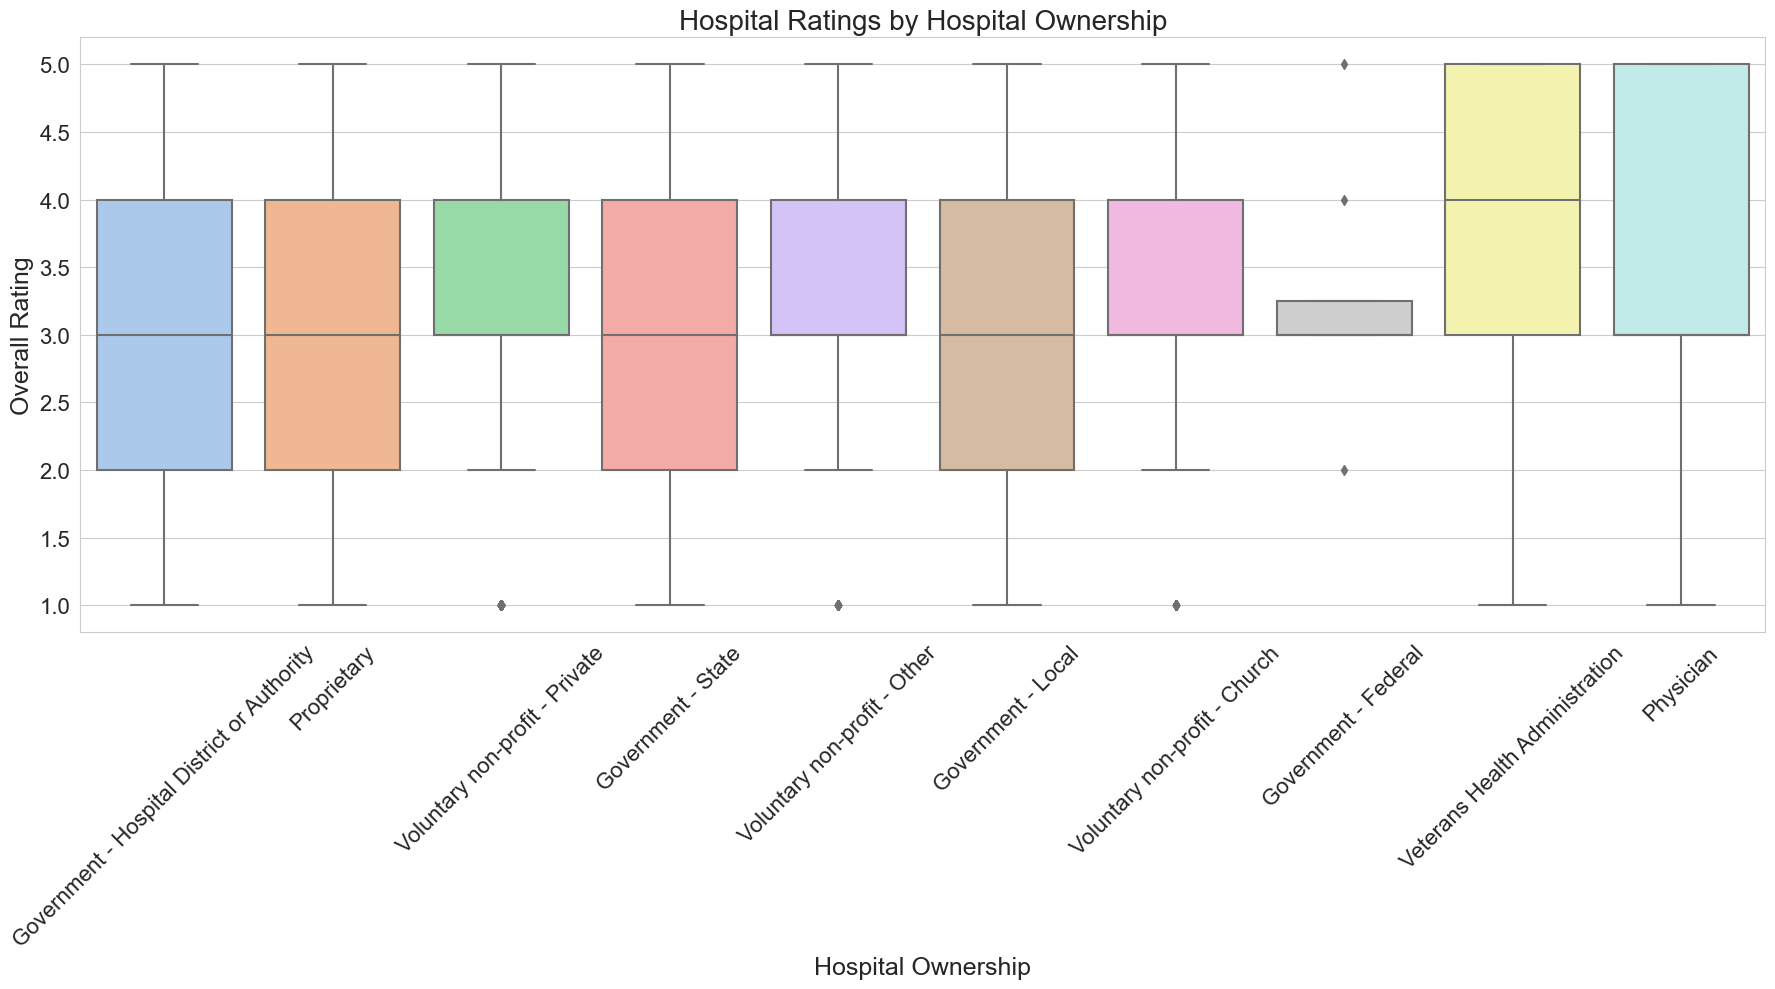

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# set fontsizes
sns.set_context(rc={
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 14
})

plt.figure(figsize=(18, 10))
sns.boxplot(data=data_filtered, x='Hospital Ownership', y='OVERALL_RATING', palette='pastel')
plt.title("Hospital Ratings by Hospital Ownership")
plt.xlabel('Hospital Ownership')
plt.ylabel('Overall Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Does mortality, readmissions and safety impact ratings?

Well, we can't necessarily infer causality from looking at correlations, but we can look at it with this context in mind and make our own informed assumptions.

We can see that there are weak positive correlations between all of the "Better" metrics, i.e. higher ratings are positively correlated with better-than-average mortality, unplanned readmission rates and hospital safety.

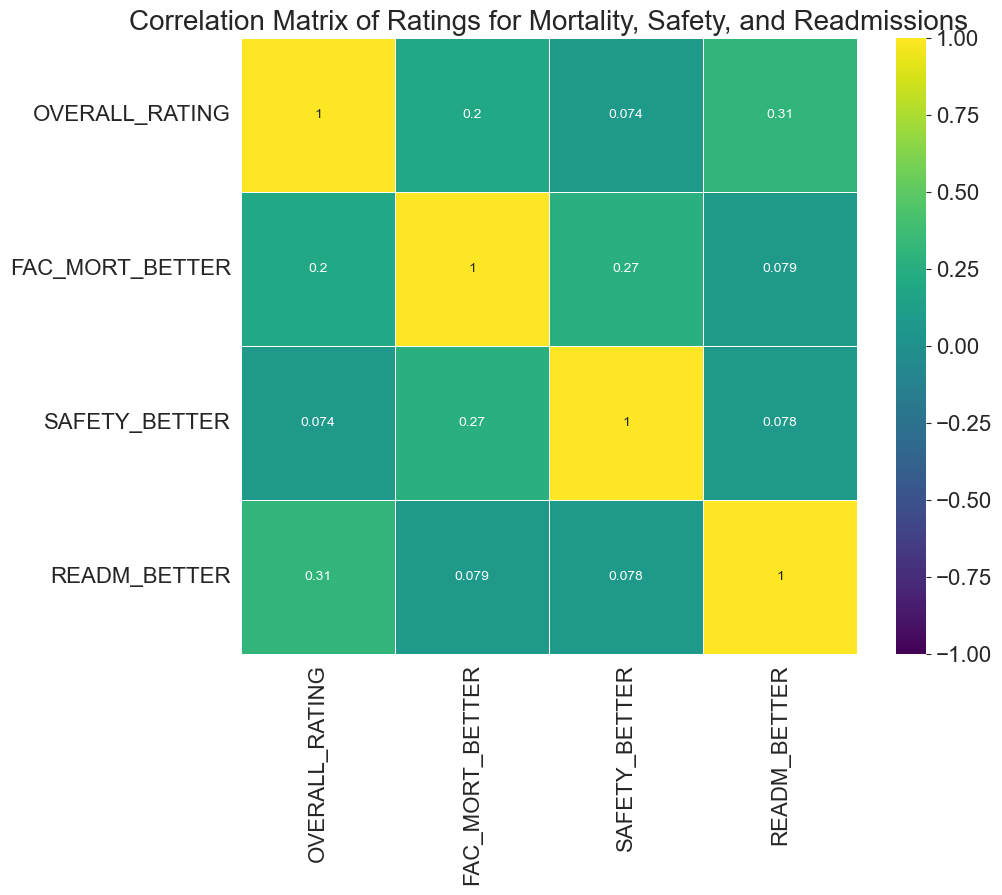

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix for selected columns
correlation_matrix = data_filtered[['OVERALL_RATING', 'FAC_MORT_BETTER', 'SAFETY_BETTER', 'READM_BETTER']].corr()

# Plot the heatmap of correlation coefficients
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', vmin=-1, vmax=1,
            square=True, linewidths=0.5)
plt.title('Correlation Matrix of Ratings for Mortality, Safety, and Readmissions')
plt.show()

# Conclusions
After pre-processing and with the additional context shown here, I'm better prepared to load this data into a SQL server or connect it to a visualization tool. I plan to use this to create a dashboard with a map of Medicare-registered hospitals and add some additional filters to create a customer-facing tool that can show users which hospitals near them have high ratings and better outcomes. My hope is that this can provide insights that improve patient outcomes by making sure that patients are going to the best hospitals near them.